# Adding jet $p_T$ and $\eta$

Ok, so  when I increased the model complexity for the hybrid training, it seemed to get as good as the ttbar performance for the 50 unit model.

However, I was also wondering if adding in jet $p_T$ and $\eta$ could help the performance of the the network. We were motivated to add in jet $p_T$ because then the classifier could learn a different decision boundary for each jet energy to be optimal over the entire range.

Michael said it would also be useful to add in $\eta$ as well, but the motivation that I could think of to add this is that knowing where the detector the jet is gives us information about the *quality* of the tracks, i.e, 9 Si hits would be more likely to be a poor quality track in the forward region, but a good quality track in the central region.


In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
HYBRID_SAMPLE = "hybrid_1.5TeV"

## Step 1: Load in the test data

## Step 2: Load in the models and the discriminants

Note: The events are lined up for the same physics sample, so we don't need to load in the data twice.


Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


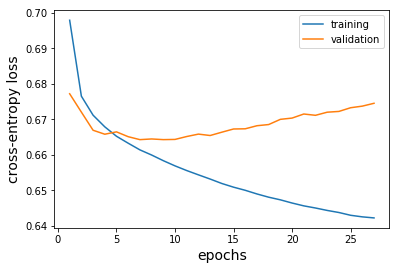

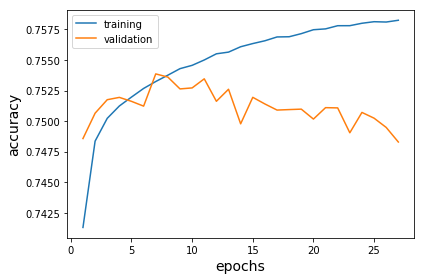

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


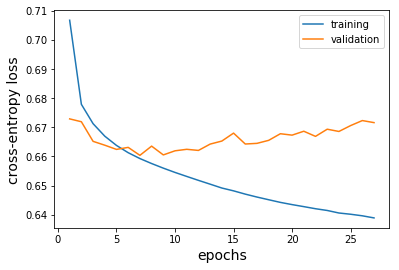

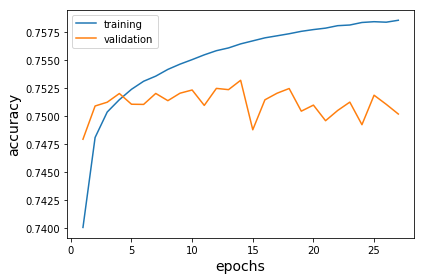

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


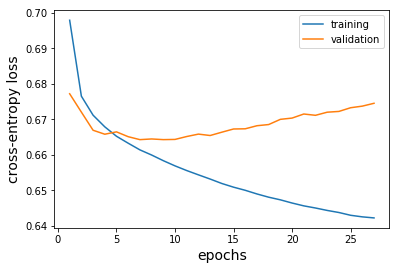

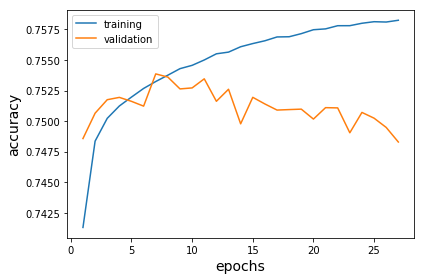

Load in the previously saved efficiency file
Initialize method from myModel()
Loading previously trained LSTM
acc
loss
val_acc
val_loss


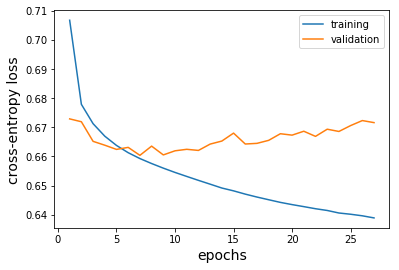

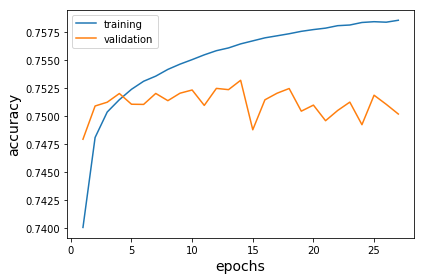

Load in the previously saved efficiency file


In [4]:
leffs, ceffs, beffs, discs = [],[],[], []
ys, pts, etas = [],[],[]

figDir = '../../figures/'
leffs, ceffs, beffs = [],[],[]
trkVarStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
jetVarStrs = ['','_pt_orig_eta_orig']

for physicsSample in ['ttbar','Zprime_1.5TeV']:
              
    # Form the variable string to access the test data
    dataDir = '../../data/mc16d_PFlow_{}'.format(physicsSample)
    dataTagTest = "2mtest{}_15trks_{}_sd0_rev_{}_scale".format(jetVarStrs[-1],trkVarStr,HYBRID_SAMPLE)

    f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
    f = h5py.File(f_name,"r")

    X = f['X_test'][:]
    X_jet = f['X_jet_test'][:]
    y = f['y_test'][:]
    ix = f['ix_test'][:]

    f.close()

    # Also save the pts, and etas when you're running w/ them in the Ntuple
    ys.append(y)
    pts.append(X_jet[:,0])
    etas.append(X_jet[:,1])


    # Load in the models
    subDir = 'mc16d_PFlow_{}'.format(HYBRID_SAMPLE)
    modelDir = '../../models/' + subDir
    nTest, nTrks, nFeatures = X.shape

    for jetVarStr, inpt in zip(jetVarStrs,[X,[X,X_jet]]):
        
        dataTagTrain = "5mtrain{}_15trks_{}_sd0_rev".format(jetVarStr,trkVarStr)
        m = myLSTM(modelDir=modelDir, nFeatures=nFeatures, nHidden=200,
                   dataTag=dataTagTrain, loadModel=True)
        
        trainingMetrics(m.modelName,modelDir=modelDir)
        
        # Access the discriminants
        (leff, ceff, beff), disc = getEffs(m, inpt, y, ix, returnDisc=True, 
                                             figDir=figDir, subDir=subDir, 
                                             modelDir=m.modelDir,tag='eval_'+physicsSample)

        leffs.append(leff)
        ceffs.append(ceff)
        beffs.append(beff)
        discs.append(disc)
        

## Step 3: Look at the roc curves

### Look at the ttbar performance

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
../../plottingFcts.py:575: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)


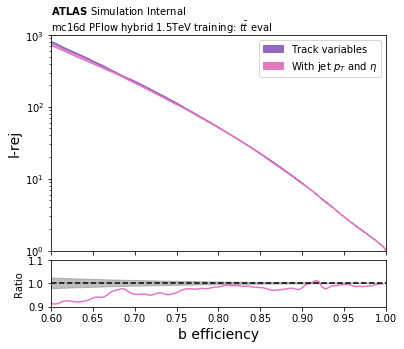

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


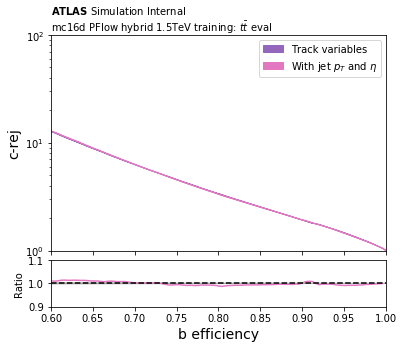

In [8]:
colors = ['C4','C6']
labels = ['Track variables','With jet $p_T$ and $\eta$']
myRange = (0.9,1.1)

text1="$\mathbf{ATLAS}$ Simulation Internal\n"
text1+="mc16d PFlow {} training: ".format(HYBRID_SAMPLE.replace("_"," "))
text1+=r"$t\bar{t}$ eval"

tag='pt_eta'

subDir1="mc16d_PFlow_ttbar"

plotROCRatio(beffs[:2], leffs[:2], labels, rrange=myRange,ymax=1000,
             text=text1,ylabel='l-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir1,tag='lrej_'+tag)

plotROCRatio(beffs[:2], ceffs[:2], labels, rrange=myRange,ymax=100,
             text=text1,ylabel='c-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir1,tag='crej_'+tag)

### Look at the Z' performance

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: divide by zero encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:165: RuntimeWarning: invalid value encountered in true_divide
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:117: RuntimeWarning: invalid value encountered in multiply
  d = ((2*h0 + h1)*m0 - h0*m1) / (h0 + h1)
../../plottingFcts.py:575: RuntimeWarning: invalid value encountered in sqrt
  eff_err = lambda x, N: np.sqrt( x*(1-x) / N)


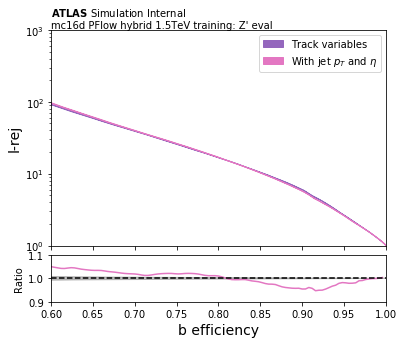

/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3_tf/lib/python3.6/site-packages/scipy/interpolate/_cubic.py:147: RuntimeWarning: invalid value encountered in true_divide
  mk = (y[1:] - y[:-1]) / hk


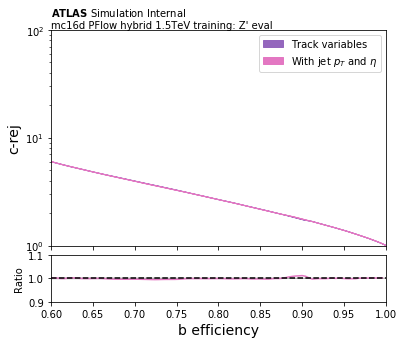

In [9]:
text2="$\mathbf{ATLAS}$ Simulation Internal\n"
text2+="mc16d PFlow {} training: ".format(HYBRID_SAMPLE.replace("_"," "))
text2+=r"Z' eval"

subDir2="mc16d_PFlow_Zprime_1.5TeV"

plotROCRatio(beffs[2:], leffs[2:], labels, rrange=myRange,ymax=1000,
             text=text2,ylabel='l-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir2,tag='lrej_'+tag)

plotROCRatio(beffs[2:], ceffs[2:], labels, rrange=myRange,ymax=100,
             text=text2,ylabel='c-rej',binomialErrors=True,nTest=nTest, 
             colors=colors, figDir=figDir,
             subDir=subDir2,tag='crej_cf_'+tag)

## Step 4: Probe the $p_T$ and $\eta$ performance

Ok, so I found it kind of wierd that the performance got worse with add these new variables for ttbar (at least), so I think the next step is to see *where* this performance loss is coming from, and whether or not it is significant.

### $t\bar{t}$ evaluation

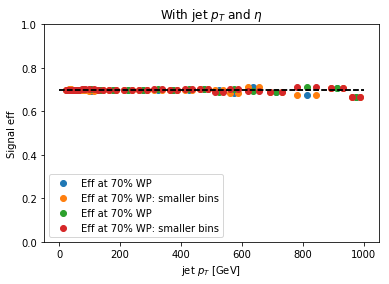

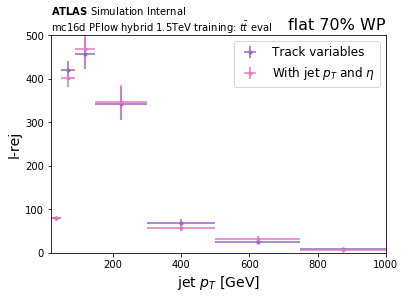

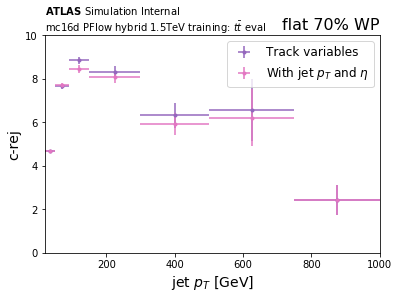

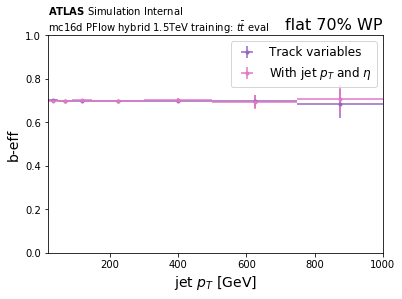

In [13]:
# ttbar - pt
plotPtDependence(pts[0],ys[0],discs[:2], labels,
                 lrej_lim=(0,500),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text1,
                 pt_edges=np.array([20, 50, 90, 150, 300, 500, 750, 1000]),
                 eff_bins = np.array([20,30,40,50,70,90,120,150,200,250,300,350,400,450,500,550,600,675,750,875,950,1000]),
                 figDir=figDir,subDir=subDir1,tag='cf_'+tag,verbose=False)

It seems like the network with the tracks might not have gotten fully optimized for the lowest jet $p_T$s. I wonder why??

Ok, so I think for $\eta$, I can use the same function, the things I'm naming the variables just aren't as intuitive.

For the $\eta$ bins, I can start w/ whatever is in the latest algorithms paper.

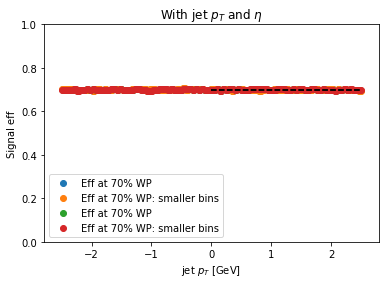

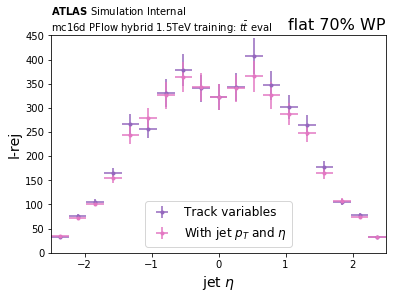

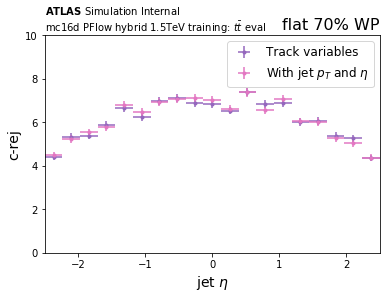

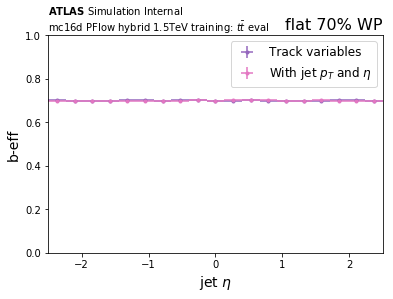

In [16]:
# ttbar - eta
eta_min = -2.5
eta_max =  2.5

plotPtDependence(etas[0],ys[0],discs[:2], labels,xlabel='jet $\eta$',
                 lrej_lim=(0,450),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text1,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir1,tag='cf_'+tag,
                 var='eta',verbose=False)


### Z' evaluation

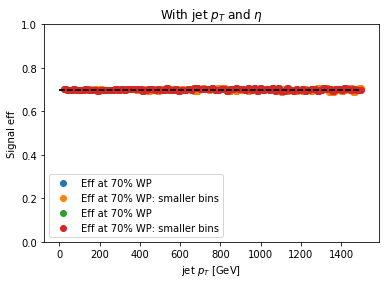

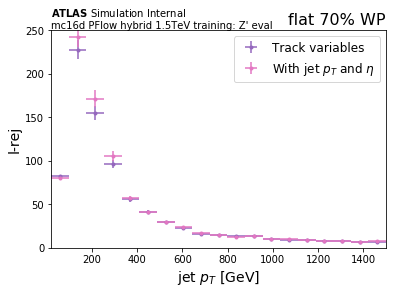

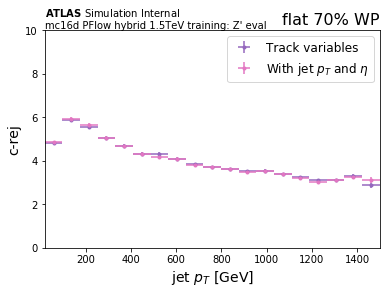

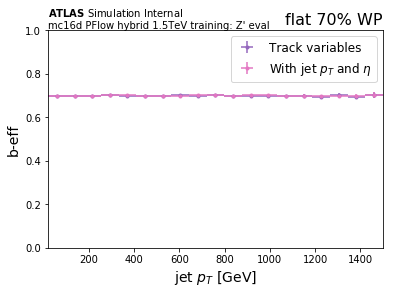

In [17]:
ptmin = 20
ptmax = 1500

subDir="mc16d_PFlow_Zprime_1.5TeV"

plotPtDependence(pts[1],ys[1],discs[2:],labels,
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text2,
                 pt_edges=np.linspace(ptmin,ptmax,20),
                 eff_bins = np.linspace(ptmin,ptmax,100),
                 figDir=figDir,subDir=subDir2,tag='cf_'+tag,verbose=False)

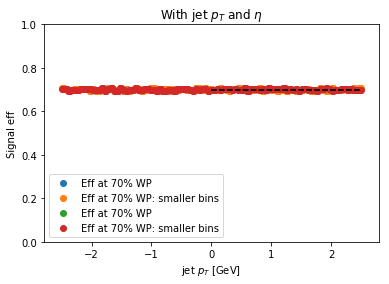

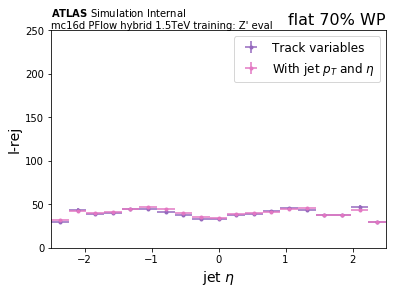

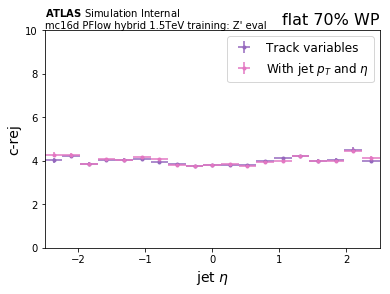

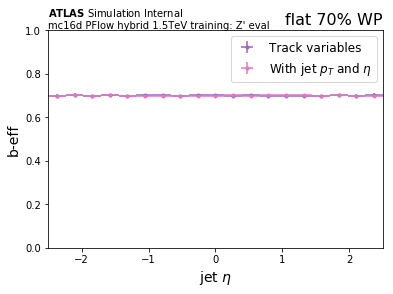

In [18]:
# ttbar - eta
plotPtDependence(etas[1],ys[1],discs[2:], labels,xlabel='jet $\eta$',
                 lrej_lim=(0,250),crej_lim=(0,10),beff_lim=(0,1),
                 flat=True,binomialErrors=True,colors=colors,text=text2,
                 pt_edges=np.linspace(eta_min,eta_max,20),
                 eff_bins = np.linspace(eta_min,eta_max,100),
                 figDir=figDir,subDir=subDir2,tag='cf_'+tag,var='eta',verbose=False)

## Step 5: Look at the Mutual information

Ok, so this was the same thing that I saw when I tried including the jet $p_T$ and $\eta$ in my PU project. 

I was concerned about the network effectively learning from the jet $p_T$ and $\eta$ given this setup that I was using, so Michael suggested that I look into the mutual information (MI) between (I think) the jet $p_T$ and discriminant probability distributions.


A way to [estimate the MI](https://arxiv.org/abs/1801.09125) is to use hash maps to map each of the random variables $X$ and $Y$ to, and the number of hash collisions can be used to estimate the MI between the distributions.

<img src="../../figures/MI_dependenceGraph.png" width="400">


### Notation

- X and Y are two random variables, that get mapped to the nodes in V and U, respectively, this is **mapping 1**

This is a *vector valued hash function* 

$$H_1(x) =  [h_{1}(x_1), h_1(x_2), \ldots, h_1(x_d)]$$

where each scalar hash function transforms each dimension of $x_i$ into an integer:


$$h_1(x) = \left \lfloor{\frac{x_i + b}{\epsilon}}\right \rfloor  $$


- Then we map the nodes in V and U to a single space, $\mathcal{F} := \{ 1, \ldots F\}$ where $F = c_H N$, and the function $H_2$ is a mapping from $Z^d \rightarrow \mathcal{F}$ st. $H_2$ had a uniform density for each output value. This is **mapping 2**.

- i,j are the indices that each var in $\mathcal{X}$ and $\mathcal{Y}$ (respectively) get mapped to in the composition of mapping 1 and mapping 2.

$H(x) := H_2(H_1(x))$

"$H(x)$ reveals the index of the mapped vertex in $G(X,Y)$."

$$\omega_i = \frac{N_i}{N}; \qquad \omega_j' = \frac{N_j}{N}; \qquad \omega_{ij} = \frac{N_{ij} N}{N_i M_j}$$

- $\omega_i$, $\omega_j'$: weights of the nodes $v_i$ and $u_j$
- $\omega_{ij}$: weight of the edge $(v_i,u_j)$

### The algorithm

<img src="../../figures/MI_alg.png" width="400">

Note: the output $\hat{I}$ returned by the alg is the estimate of the MI between the two variables.

### Choices

Ok, so there is a lot of information already, but maybe I need to make some decisions:
- Let $\epsilon = 0.1$
- $b = \epsilon /2$
- $c_H = 100$


In [43]:
def H1(x,eps,b):
    return np.floor((x-eps)/b)
    
    
def H2(v):
    return hash(tuple(v))


def H(x,eps,b):
    '''
    Returns the composition H2(H1(x))
    '''
    return H2(H1(x,eps,b))

def g(x):

    return x*np.log(x)
    
def gtilde(x,g,maxVal=1000):
    '''
    Inputs:
    - x: input
    - g: function
    - maxVal
    '''
    return max(g(x),maxVal)

In [3]:
def optimalEps(N,d):
    '''
    Calculate the hash parameter that gives the optimal bias.
    
    Inputs:
    - N: number of examples
    - d: The sum of the X and Y dimensions
    
    Outputs:
    - eps: hash parameter
    '''
    
    eps = np.power(N,-1/(1+d))
    return eps

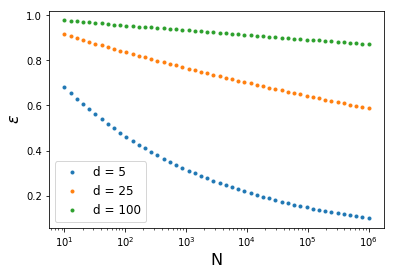

In [17]:
Ns = np.logspace(1,6)

for d in [5,25,100]:
    epsilons = optimalEps(Ns,d)

    plt.semilogx(Ns,epsilons,'.',label='d = {}'.format(d))
plt.xlabel('N',fontsize=16)
plt.ylabel('$\epsilon$',fontsize=16)
plt.legend(fontsize=12)

plt.savefig("../../figures/MI_studies/optimalEps.pdf")
plt.show()

In [44]:
def MutualInformation(X,Y, cH=100):
    '''
    
    Inputs:
    - X,Y A set of samples of RVs drawn from two dists
    - eps: the hash parameter
    - b: A fixed RV in [0,eps]
    - cH: fixed tunable integer
    
    Output:
    - I: The estimate of the MI for the dists of the samples
         drawn from X and Y
    
    '''
    
    Nx, dx = X.shape
    Ny, dy = Y.shape

    assert Nx == Ny
    
    N = Nx
    d = dx+dy
    
    eps = optimalEps(N,d)
    b = 0.5 * eps
     
    # Get the hash map - note, i,j are indexed from 0, instead
    # of using the paper's convention which starts @ 1.
    vs = np.zeros(N)
    us = np.zeros(N)
    for i,(xi,yi) in enumerate(zip(X,Y)):
        vs[i] = H(xi,eps,b)
        us[i] = H(yi,eps,b)
        
      
    return vs,us
    
    '''
    Count the hash collisions
    '''
#     wi  = np.zeros()
#     wj  = 
#     wij =
    
    

In [38]:
X = np.random.randn(1000,2)
Y = X**2

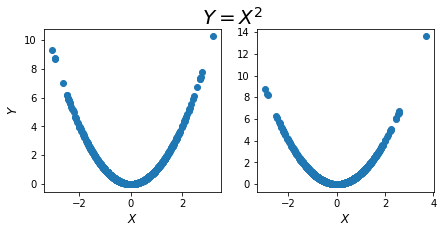

In [72]:
fig, axes = plt.subplots(1,2,figsize=(7,3))#,sharey=True)

for i,ax in enumerate(axes):
    
    ax.scatter(X[:,i],Y[:,i])
    ax.set_xlabel("$X$",fontsize=12)
    if i == 0: ax.set_ylabel("$Y$",fontsize=12)
    
plt.suptitle("$Y = X^2$",fontsize=20)
plt.show()

In [73]:
#us,vs = MutualInformation(X.reshape(-1,1),Y.reshape(-1,1))
us,vs = MutualInformation(X,Y)

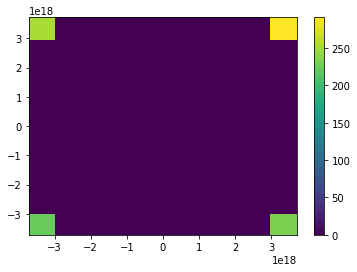

In [79]:
plt.hist2d(us,vs)
plt.colorbar()
plt.show()

In [80]:
X = np.random.randn(1000,2)
Y = np.random.randn(1000,2)

In [81]:
us,vs = MutualInformation(X,Y)

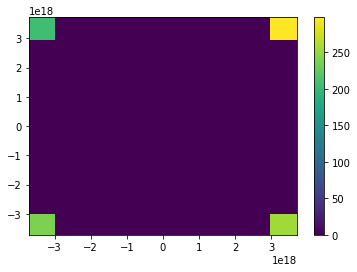

In [82]:
plt.hist2d(us,vs)
plt.colorbar()
plt.show()

It's practically the same thing... so *clearly* something is wrong here ;(

In [2]:
sys.path.append("../../../EDGE")
from EDGE_4_3_1 import EDGE
from tqdm import tqdm

In [16]:
Is = []

Ns = [1000,5000,10000,50000,int(1e5)]

for N in tqdm(Ns):
    X = np.random.randn(N,2)
    Y = X**2
    I = EDGE(X,Y)
    Is.append(I)



100%|██████████| 5/5 [01:17<00:00, 20.01s/it]

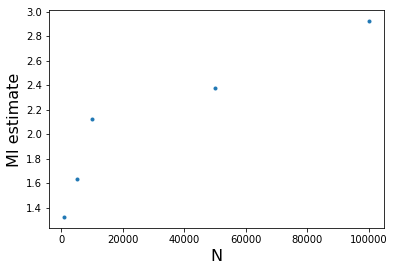

In [17]:
plt.scatter(Ns,Is,marker='.')
plt.xlabel('N',fontsize=16)
plt.ylabel('MI estimate',fontsize=16)
  
plt.show()

In [13]:
Is = []

Ns = [1000,5000,10000,50000,int(1e5)]

for N in tqdm(Ns):
    X = np.random.randn(N,2)
    Y = np.random.randn(N,2)
    I = EDGE(X,Y)
    Is.append(I)



100%|██████████| 5/5 [01:17<00:00, 20.06s/it]

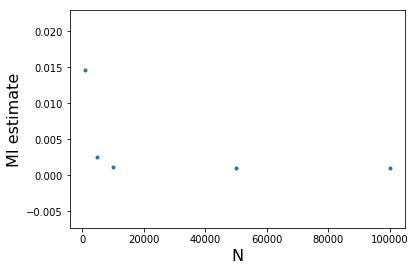

In [15]:
plt.scatter(Ns,Is,marker='.')
plt.xlabel('N',fontsize=16)
plt.ylabel('MI estimate',fontsize=16)
  
plt.show()